<a href="https://colab.research.google.com/github/liuy01510/portfolio/blob/master/Data_Science_I_Singapore_Resale_Flat_Dataset_PF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
- The dataset involved will be the resale prices of the housing flats in Singapore from the period of 2000 to 2020.

# Loading the datasets

## Importing the required libraries

In [0]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import zipfile
import datetime
import collections as coll
import scipy.stats

In [22]:
# Requesting the datasets from the source 
## API usage was initially considered, but throughput was too low given the large amount of entries.
## Therefore, direct downloads and extraction of the CSV files are employed instead.
url='https://data.gov.sg/dataset/7a339d20-3c57-4b11-a695-9348adfd7614/download'


# Creating dicts to hold references to the various objects
all_tables={} # table dict
all_charts={} # chart dict
v={} # variable dict

# Function for data extraction
def Get_Resale_Data(url):
    """
    Extracts the data from the url and returns a Dataframe.

    type(url) ==  string

    type(resource_id) == iterable

    Returns a dataframe containing all the resources
    """
    result=pd.DataFrame() # create an empty dataframe to store the result
    csvFiles=[]

    # Getting the zip file from the server
    reply=requests.get(url).content # getting the content of the response object from the server.
    with open('/content/Zipped_Dataset','wb') as zf: # writing the file into the VM storage
        zf.write(reply) # writing the zip file into the local file.

    # Unzipping and extracting the csv files.
    with zipfile.ZipFile('/content/Zipped_Dataset') as f: # Opening the zipped file.
        for fileName in f.namelist(): # loop through all the files within the zipped file.
            if '.csv' in fileName: # only extract the csv file.
                csvFiles.append(fileName) # append to the csvFiles list for easier referencing.
                f.extract(fileName,path='/content') # extracting the files into the local folder.
    
    # Adding the data from the csv files into the dataframe.
    for fileName in csvFiles: # opening each csv file
        filePath=f"/content/{fileName}" # getting the filepath for each of the csv file.
        with open(filePath,mode='rb') as f: # opening each csv file.
            csv=pd.read_csv(f) # reading each csv file into a temp dataframe.
            result=result.append(csv) # appending the temp csv dataframe into the result dataframe

    return result

# Initializing data extraction
## Only perform data extraction if the data has not been downloaded
try: 
    len(masterCopy)
except:
    masterCopy=Get_Resale_Data(url)

## Assigning the raw Data to the dict
all_tables['allData']=masterCopy.copy(deep=True)

all_tables['allData']

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
287195,1999-12,YISHUN,EXECUTIVE,611,YISHUN ST 61,10 TO 12,142.0,APARTMENT,1987,NaN,456000.0
287196,1999-12,YISHUN,EXECUTIVE,324,YISHUN CTRL,01 TO 03,142.0,APARTMENT,1988,NaN,408000.0
287197,1999-12,YISHUN,EXECUTIVE,392,YISHUN AVE 6,07 TO 09,146.0,MAISONETTE,1988,NaN,469000.0
287198,1999-12,YISHUN,EXECUTIVE,356,YISHUN RING RD,04 TO 06,146.0,MAISONETTE,1988,NaN,440000.0


# Data Cleaning

In [23]:
# Converting the date from string to date objects for easier parsing.
x=all_tables['allData']['month'] # assign to temp var x.
x=[i.split('-') for i in x] # splitting based on the '-' symbol.
all_tables['allData']['month']=[datetime.date(int(i[0]),int(i[1]),1) for i in x] # creating new datetime objects.

# Reindexing the table
table=all_tables['allData']
all_tables['allData']=table.reset_index().drop(columns=['index'])
all_tables['allData']

# splitting the month into more specific dates
table=all_tables['allData']

def Date_Clean(date,dateType=None):
    """

    Pass a iterable containing an iterable of date objects. 

    Choose the type of date data to be returned. 

    Args for dateType --> 'year','month','quarter'. If not specified, a tuple in the form (year,month,quarter) will be returned.
    """
    _quarterDict={} # identifies the quarter of the month based on the given month
    for q,m in zip([1]*3+[2]*3+[3]*3+[4]*3,[i for i in range(1,13)]):
        _quarterDict[m]=q
        
    _date=date # pass into function variable.
    _dT=dateType
    if type(_date)!=datetime.date: # data type check
        raise ValueError(f"{_date} is not a date object.")
    if _dT=='year':
        return _date.year
    elif _dT=='month':
        return _date.month
    elif _dT=='quarter':
        return _quarterDict[_date.month]
    else:
        return (_date.year,_date.month,_quarterDict[_date.month])

## Cleaning up the dates of the data
table['months']=[Date_Clean(i,'month') for i in table['month']]
table['year']=[Date_Clean(i,'year') for i in table['month']]
table['quarter']=[Date_Clean(i,'quarter') for i in table['month']]
table=table.drop(columns='month')
all_tables['allData']=table

all_tables['allData']

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,months,year,quarter
0,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,1,2017,1
1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,1,2017,1
2,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,1,2017,1
3,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,1,2017,1
4,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,1,2017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
816305,YISHUN,EXECUTIVE,611,YISHUN ST 61,10 TO 12,142.0,APARTMENT,1987,NaN,456000.0,12,1999,4
816306,YISHUN,EXECUTIVE,324,YISHUN CTRL,01 TO 03,142.0,APARTMENT,1988,NaN,408000.0,12,1999,4
816307,YISHUN,EXECUTIVE,392,YISHUN AVE 6,07 TO 09,146.0,MAISONETTE,1988,NaN,469000.0,12,1999,4
816308,YISHUN,EXECUTIVE,356,YISHUN RING RD,04 TO 06,146.0,MAISONETTE,1988,NaN,440000.0,12,1999,4


# Applying the HDB resale pricing index
- Accounts for the inflation rate throughout the years

In [24]:
# Getting the data from the API

def Get_API_Data(url,params,responseType='json'):
    """
    Arguments:
    - url = url to the API (str type).
    - params = additional params to be supplied to the url args (dict type).
    """
    _url=url
    _params=params
    _rT=responseType

    response=requests.get(_url,params=_params).content # returns the content of the response
    if _rT=='json':
        _response=json.loads(response) # loads the response into a json file
    if _response['success']==True:
        return _response
    else:
        print('Data cannot be retrieved successfully. Please check url and params.')

# Getting the resale price index API parameters
url2='https://data.gov.sg/api/action/datastore_search'
params2={'resource_id':'52e93430-01b7-4de0-80df-bc83d0afed40','limit':10*100}
try:
    v['index'],keys() # will not request the API if the index is already available.
except:
    response=Get_API_Data(url2,params2) # obtains the required data

## Creating a dict to store the index data
v['index']=coll.OrderedDict()
d=v['index']
for entry in response['result']['records']:
    date=entry['quarter'].split('-') # splitting the date string.
    y=date[0]
    q=date[1][1:]
    d[f"{y},{q}"]=entry['index']
for key in d.keys(): # converting all the index values into floats.
    d[key]=float(d[key])
v['index']=d

# Applying the resale index to the current table
table=all_tables['allData']

## Using Q1 2017 as the base index
bI=v['Base Index']=v['index'][f"2017,1"]
table['adjustment_index']=[bI/v['index'][f"{y},{d}"] 
                                for y,d in zip(table['year'],table['quarter'])]

## Adjusted price calculation
table['adjusted_resale_price']=[p*i for p,i in zip(table['resale_price'],table['adjustment_index'])]
all_tables['allData']=table
all_tables['allData']

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,months,year,quarter,adjustment_index,adjusted_resale_price
0,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,1,2017,1,1.000000,232000.000000
1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,1,2017,1,1.000000,250000.000000
2,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,1,2017,1,1.000000,262000.000000
3,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,1,2017,1,1.000000,265000.000000
4,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,1,2017,1,1.000000,265000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816305,YISHUN,EXECUTIVE,611,YISHUN ST 61,10 TO 12,142.0,APARTMENT,1987,NaN,456000.0,12,1999,4,1.677945,765142.857143
816306,YISHUN,EXECUTIVE,324,YISHUN CTRL,01 TO 03,142.0,APARTMENT,1988,NaN,408000.0,12,1999,4,1.677945,684601.503759
816307,YISHUN,EXECUTIVE,392,YISHUN AVE 6,07 TO 09,146.0,MAISONETTE,1988,NaN,469000.0,12,1999,4,1.677945,786956.140351
816308,YISHUN,EXECUTIVE,356,YISHUN RING RD,04 TO 06,146.0,MAISONETTE,1988,NaN,440000.0,12,1999,4,1.677945,738295.739348


# Data Exploration

## General data exploration

In [0]:
# Creating the plotter object
def Plot(size=(17,4),dpi=300):
    """
    Constructor function for the plot object.
    Returns (fig,ax) with type (Figure,Axes).
    """
    _size=size
    _dpi=dpi
    fig=plt.Figure(figsize=_size,dpi=_dpi)
    ax=fig.add_subplot(111)
    return (fig,ax)

    

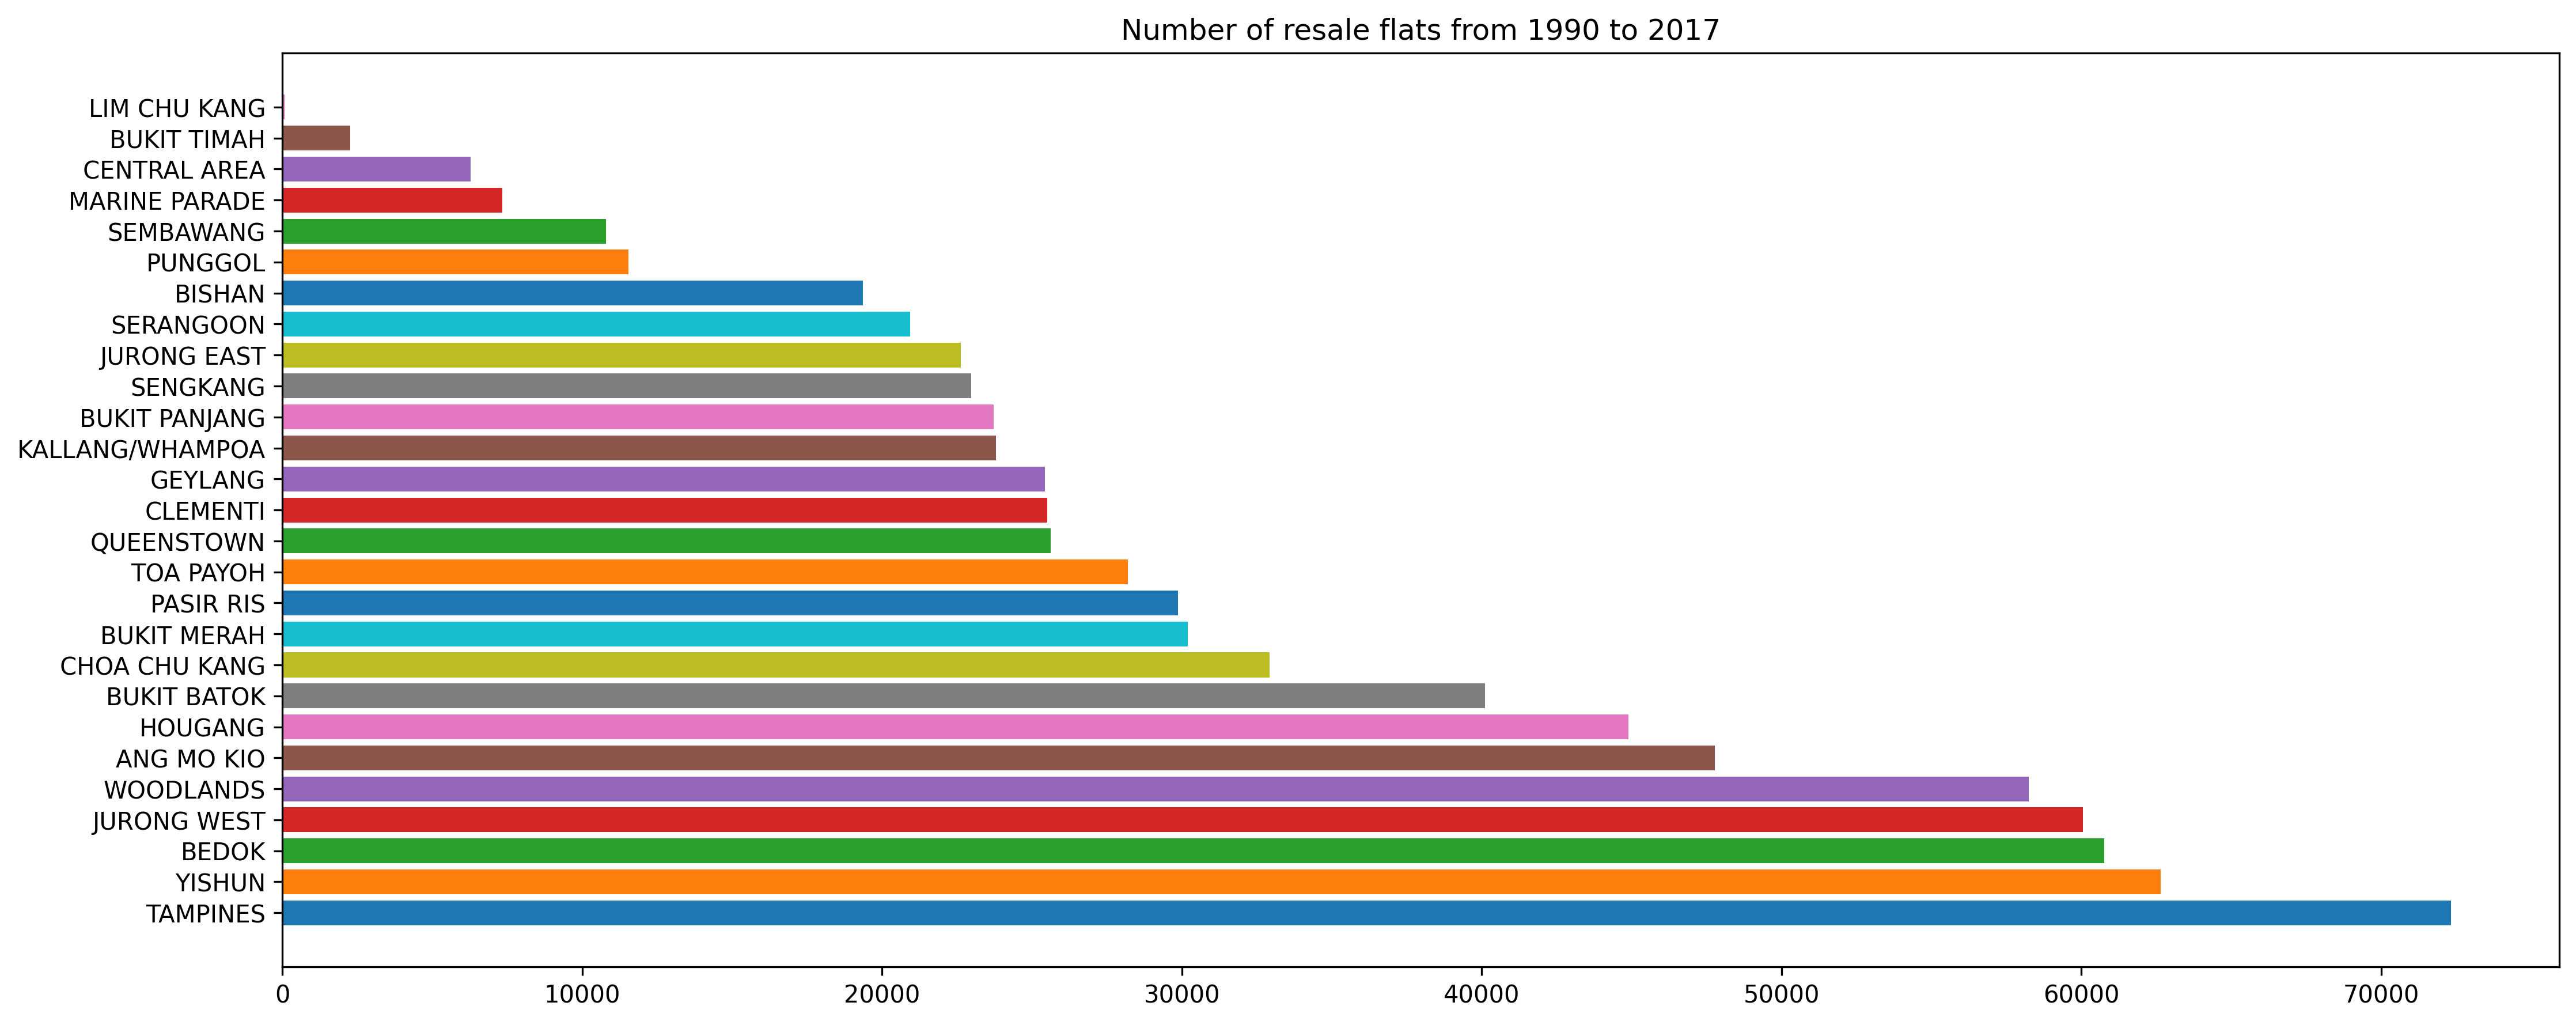

In [26]:
# See which towns has the highest number of resale units throughout the years
table=all_tables['allData']
x=coll.Counter(table['town'])
fig,ax=Plot(size=(17,7))
result={}
for i in x.keys():
    result[i]=x[i]
result={k:v for k,v in sorted(result.items(),key=lambda x:-x[1])} # sorting in decreasing order
for k,v in result.items():
    ax.barh(k,v)
ax.set_title('Number of resale flats from 1990 to 2017')
fig

## Average price of resale flat in each area
- Since the flat prices varies drastically based on the number of rooms, thus for this comparison, 3 room flats will be used.

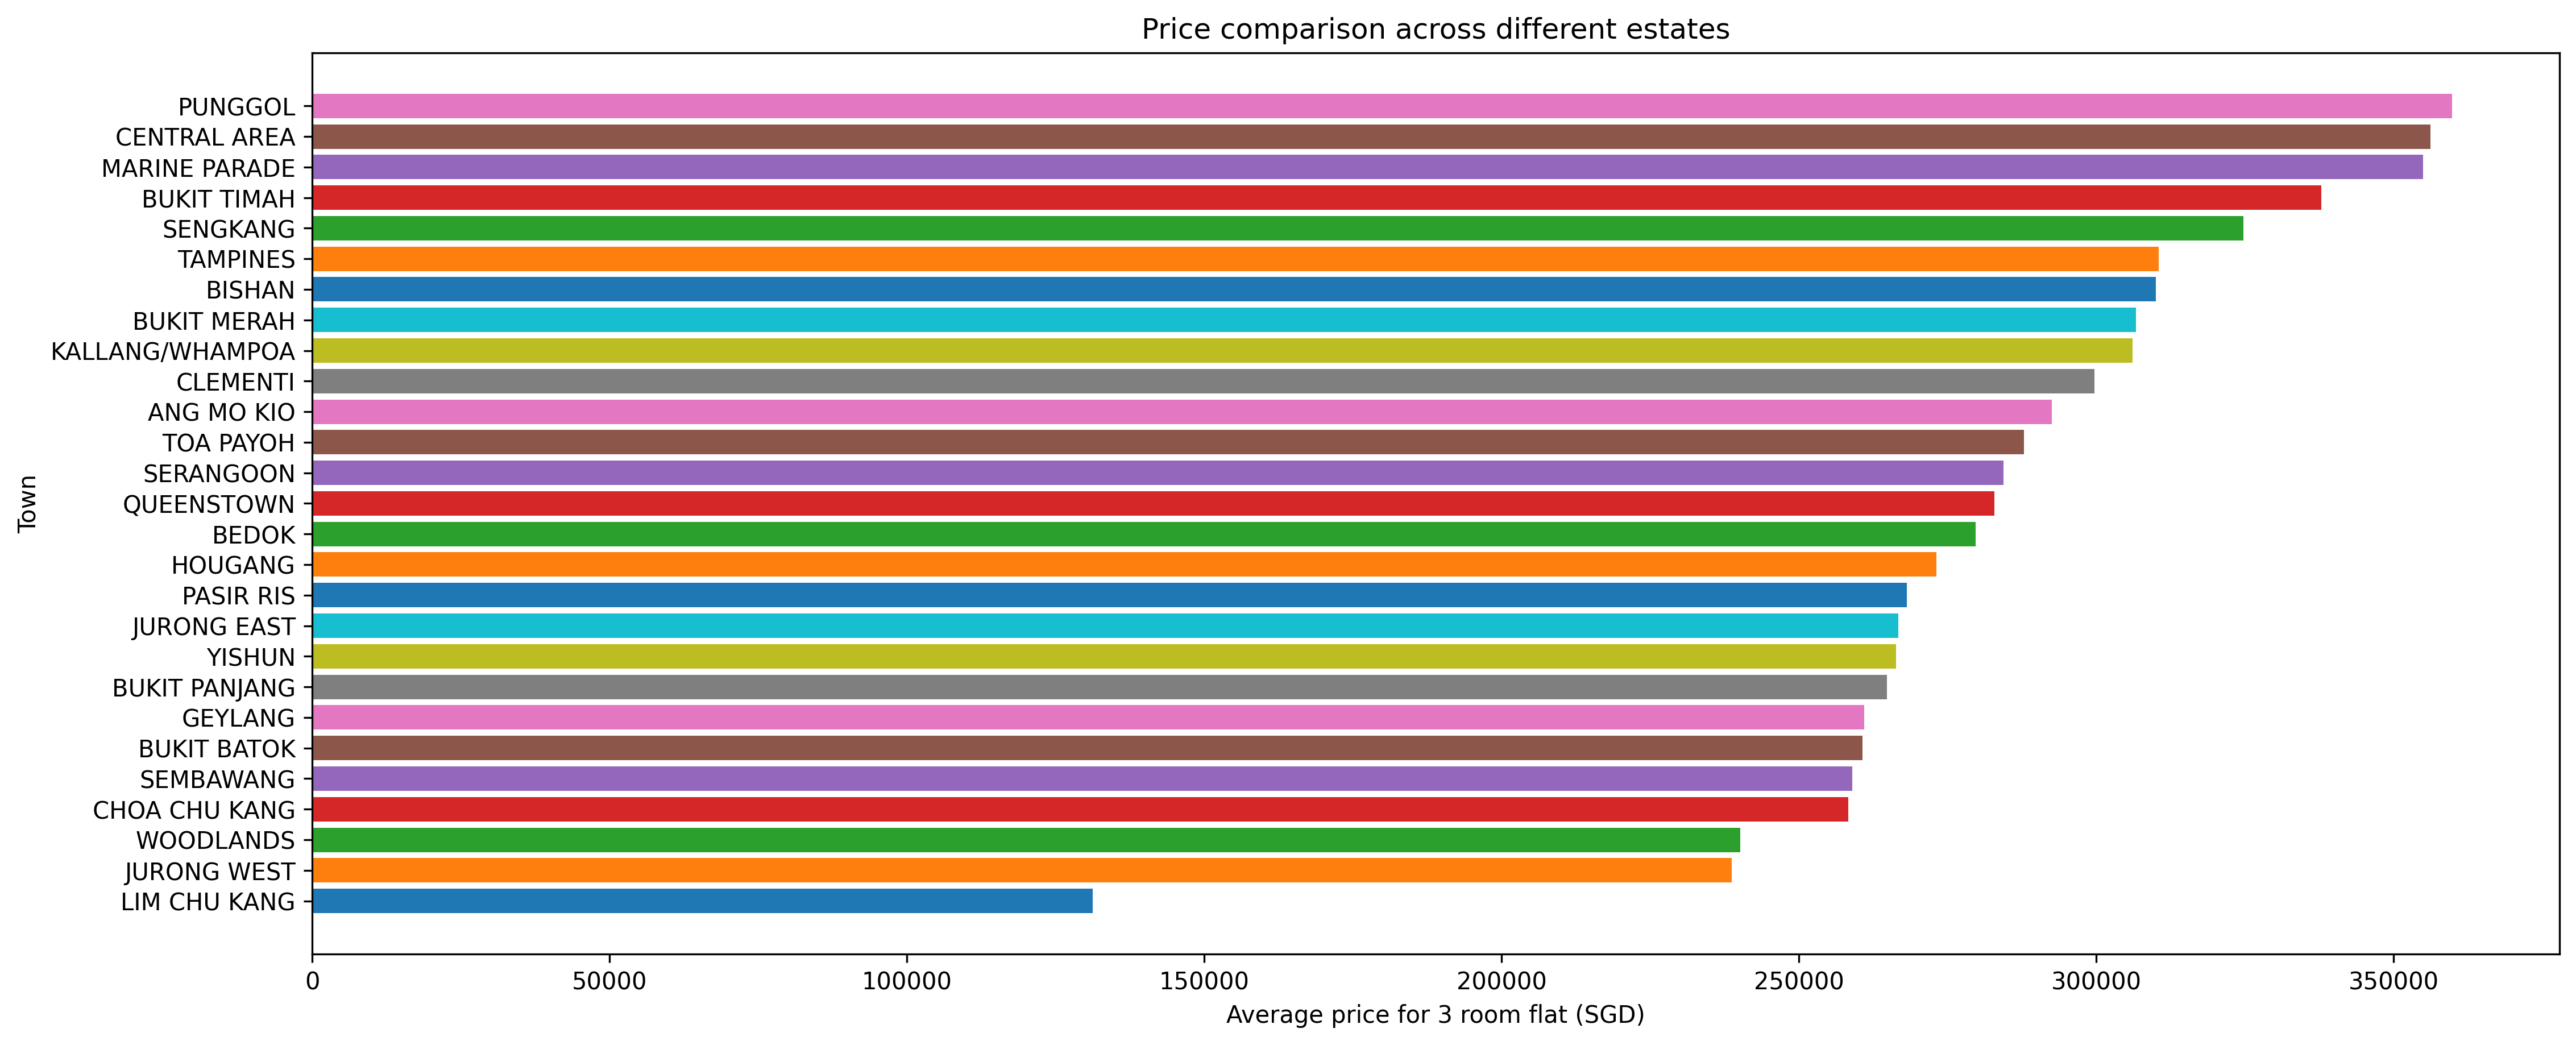

In [27]:
# Grouping each area by their town attr
grouped=table.groupby(['town','flat_type'])
fig,ax=Plot(size=(17,7))
result=coll.OrderedDict() # stores the result
for i,d in grouped:
    if i[1]=='3 ROOM': # filter out only the 3 room flats.
        town=i[0] # store the town name
        result[town]=np.average(d['adjusted_resale_price']) # average price of the 3 room flat.
result={k:v for k,v in sorted(result.items(),key=lambda x:x[1])}
for k,v in result.items():
    ax.barh(k,v)
ax.set_xlabel('Average price for 3 room flat (SGD)')
ax.set_ylabel('Town')
ax.set_title('Price comparison across different estates')
fig

## Trend of resale prices across the years
- Tampines will be used for the visualization in this case, since it has the largest number of resale flats over the years.

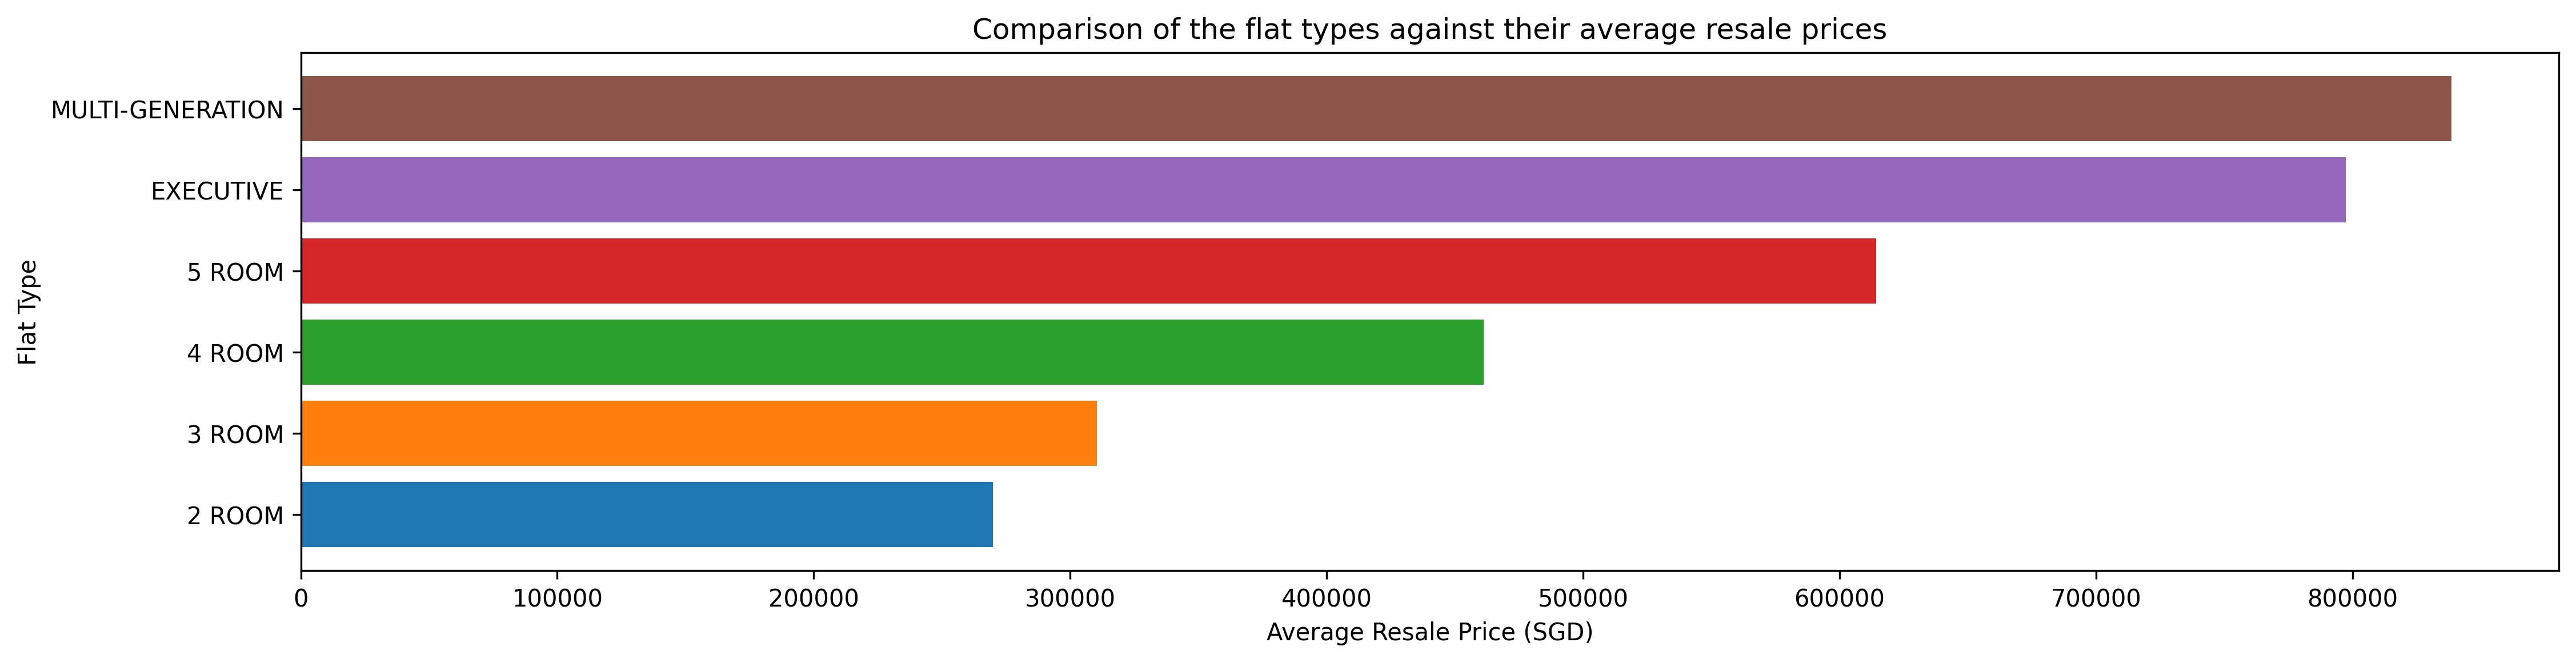

In [28]:
# Filtering out tampines estates only.
table=all_tables['allData']
table=table[table['town']=='TAMPINES']

## Reworking the flat_type to convert the "MULTI GENERATION" type to "MULTI-GENERATION" type.
table=table.replace(to_replace={'flat_type':'MULTI GENERATION'},value='MULTI-GENERATION')
# Grouping the flat types
grouped=table.groupby('flat_type')
result={}
for i,g in grouped:
    result[i]=np.average(g['adjusted_resale_price'])
result={k:v for k,v in sorted(result.items(),key=lambda x:x[1])} # sorting based on the adjusted resale price.
fig,ax=Plot()
for k,v in result.items():
    ax.barh(k,v)
ax.set_ylabel('Flat Type')
ax.set_xlabel('Average Resale Price (SGD)')
ax.set_title('Comparison of the flat types against their average resale prices')
fig

## Distribution of the flat prices
- Again, since the price of the flats differs based on the region and the flat type, a standardardized dataset should be used.
- In this case, 3-room flat types from Tampines will be used as the base sample for distribution exploration.

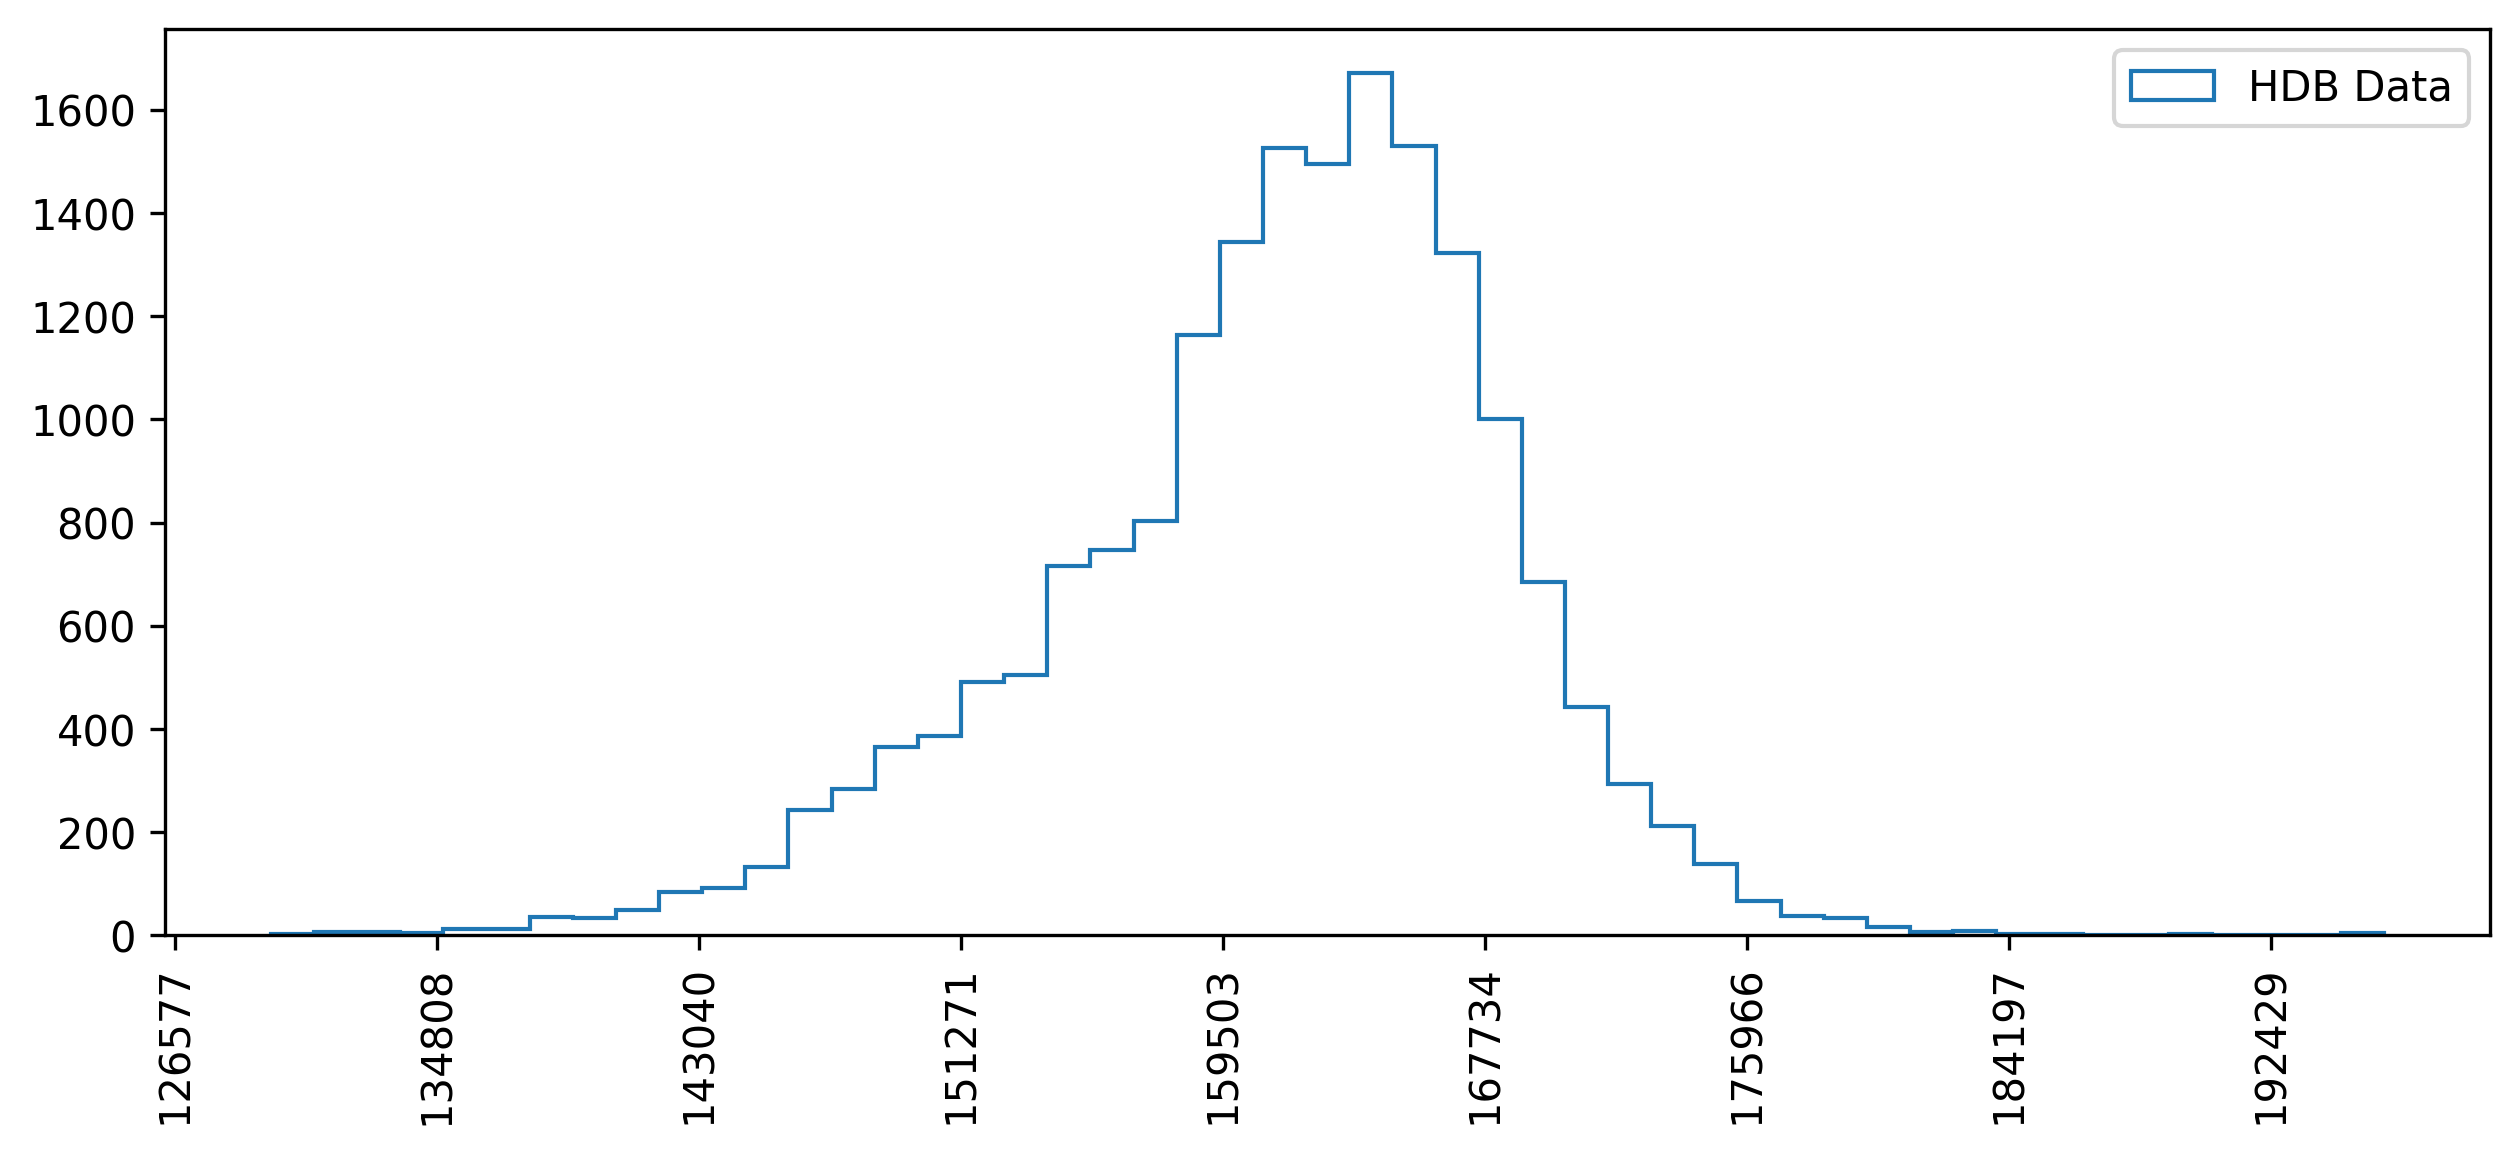

In [29]:
# Filtering out Tampines 3-room flats
table=all_tables['allData']
grouped=table.groupby(by=['town','flat_type'])
subtable=grouped.get_group(('TAMPINES','3 ROOM'))

# Plotting a histogram 
fig,ax=Plot(size=(10,4),dpi=300)
maxVal=max(subtable['adjusted_resale_price'])
minVal=min(subtable['adjusted_resale_price'])
bins=np.linspace(minVal,maxVal,num=50)
ax.hist(subtable['adjusted_resale_price'],bins=bins,density=False,histtype='step',label='HDB Data')
ax.set_xticklabels([int(i) for i in bins],rotation='vertical')


ax.legend()

fig

- As seen from the plot table, the distributions roughly represents a normal distribution. 
- The z-score to convert the data into a standard normal distribution plot.

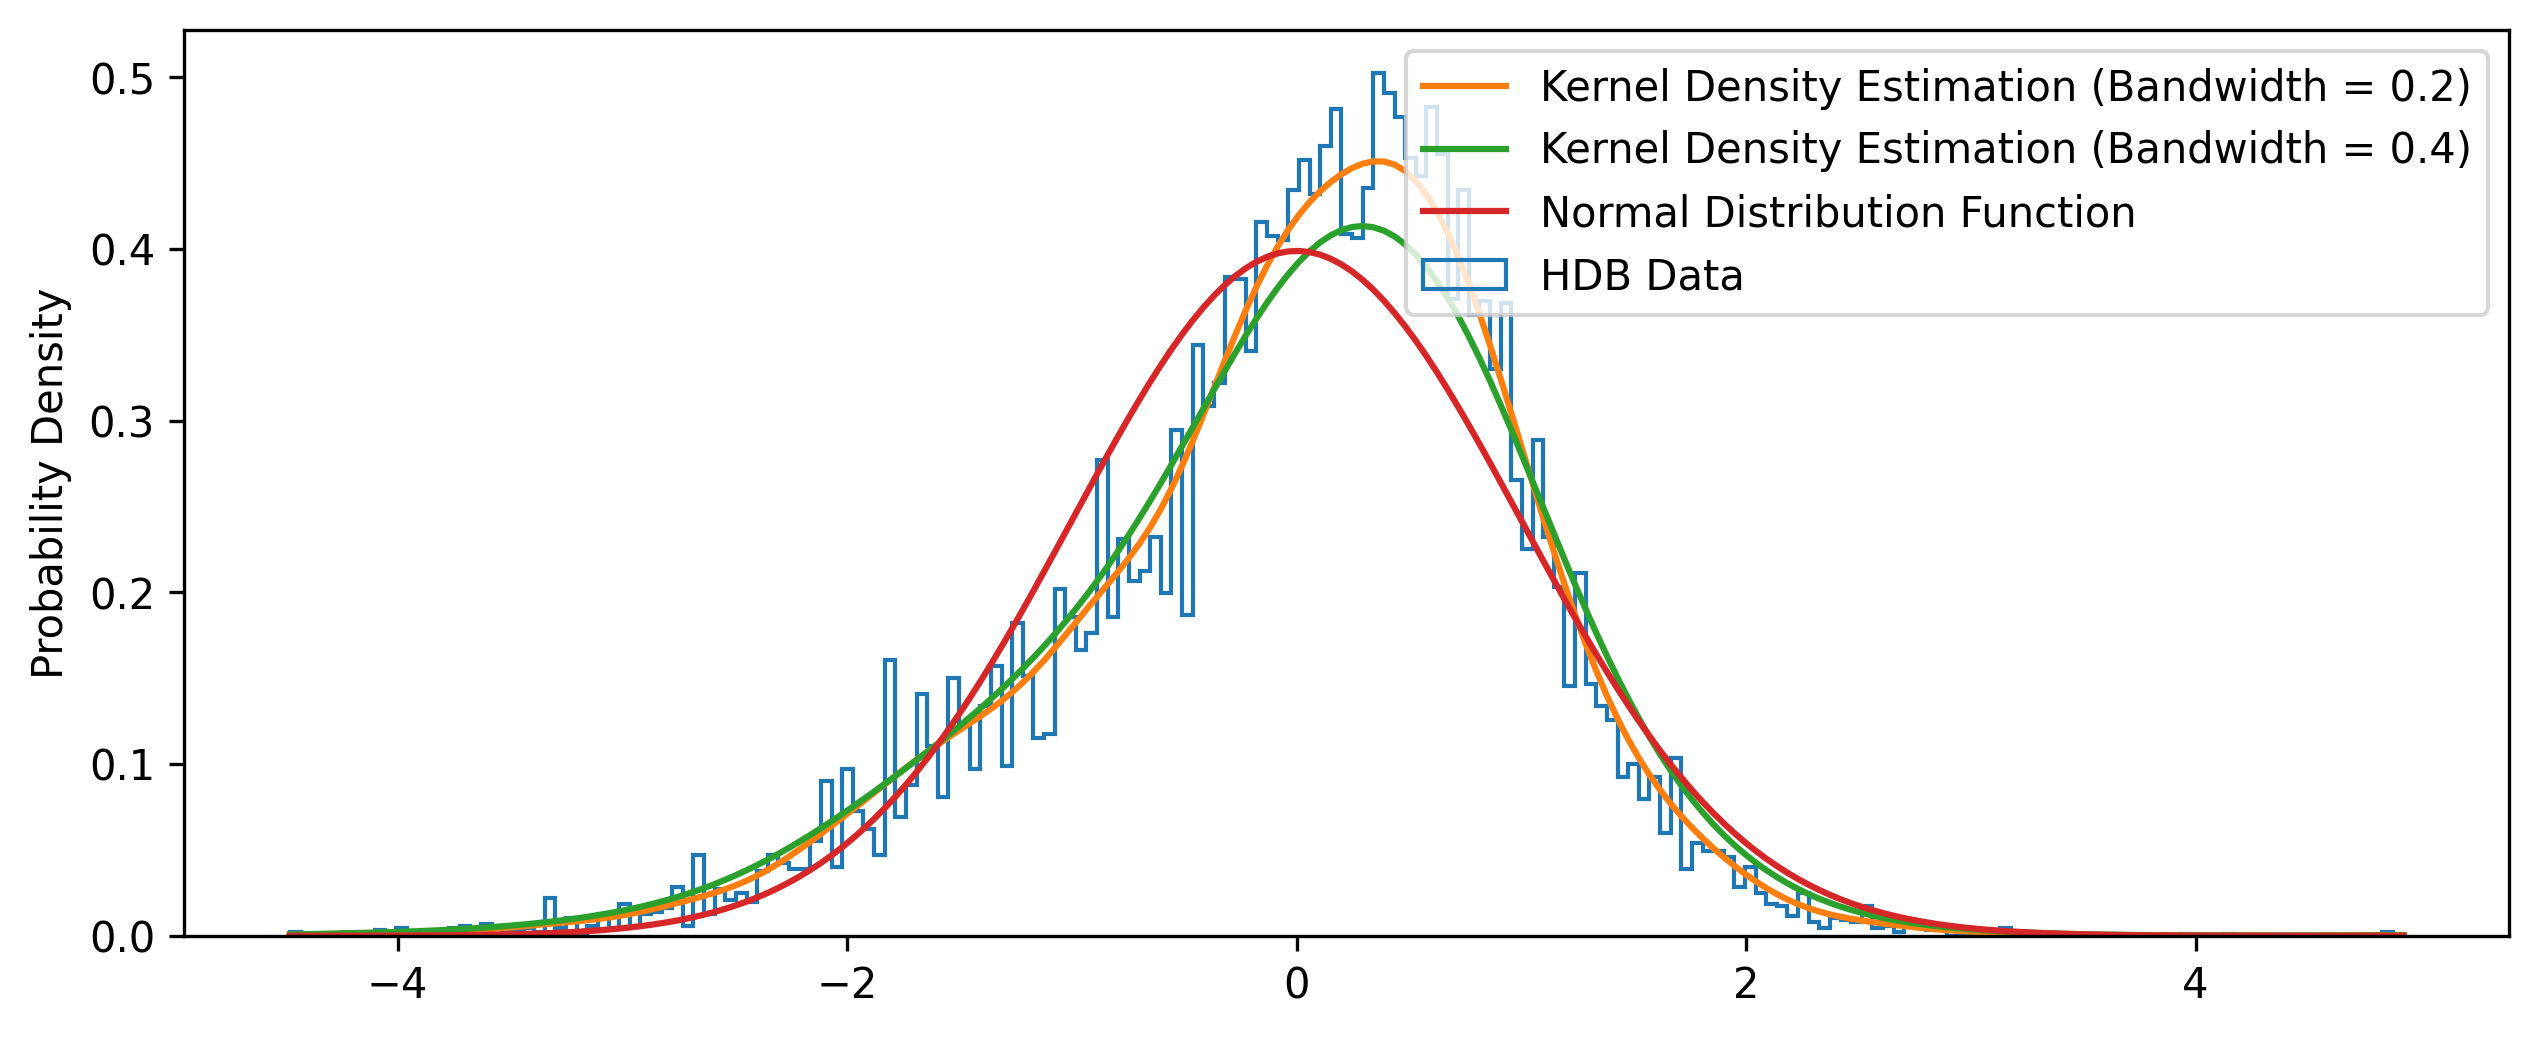

In [30]:
# Calculating the z score
zScore=scipy.stats.zscore(subtable['adjusted_resale_price'])
fig,ax=Plot(size=(10,4),dpi=300)
bins=np.linspace(min(zScore),max(zScore),200)
y,x,_=ax.hist(zScore,bins,density=True,histtype='step',label='HDB Data')



## Labelling the axis
ax.set_ylabel('Probability Density')

# Plotting the Kernel Distribution Estimate curve
x=np.linspace(min(zScore),max(zScore),200)
KDE=scipy.stats.gaussian_kde(zScore) # Fitting the z scores into the KDE instance
bw=0.2
KDE.set_bandwidth(bw_method=bw) # KDE with bandwidth of 0.2
y=KDE(x) # calling the KDE instance to predict the corresponding fitted y values.
ax.plot(x,y,label=f'Kernel Density Estimation (Bandwidth = {bw})') # plotting the data
bw=0.4
KDE.set_bandwidth(bw_method=bw) # KDE with bandwidth of 0.2
y=KDE(x) # calling the KDE instance to predict the corresponding fitted y values.
ax.plot(x,y,label=f'Kernel Density Estimation (Bandwidth = {bw})') # plotting the data

# Plotting alongside a continuous normal distribution variable
x=np.linspace(min(zScore),max(zScore),200)
y=scipy.stats.norm.pdf(x)
ax.plot(x,y,label='Normal Distribution Function')




ax.legend()

fig